### Autoregressive Integrated Moving Averages(ARIMA)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
test = pd.read_csv("test_csv.csv")

In [2]:
train = pd.read_csv("train_csv.csv")

In [3]:
train.head()

,id,time,feature
0,0,2019-03-19 00:00:00,237.97
1,1,2019-03-19 00:00:10,57.93
2,2,2019-03-19 00:00:20,90.53
3,3,2019-03-19 00:00:30,260.75
4,4,2019-03-19 00:00:40,49.70


In [4]:
test.head()

,id,time
0,80,2019-03-19 00:13:20
1,81,2019-03-19 00:13:30
2,82,2019-03-19 00:13:40
3,83,2019-03-19 00:13:50
4,84,2019-03-19 00:14:00


In [ ]:
train['time']= pd.to_datetime(train['time']) 

In [91]:
test['time']= pd.to_datetime(test['time'])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
id         80 non-null int64
time       80 non-null datetime64[ns]
feature    80 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 KB


In [7]:
train.describe()

,id,feature
count,80.0000,80.000000
mean,39.5000,147.496375
std,23.2379,96.846260
min,0.0000,21.360000
25%,19.7500,66.730000
50%,39.5000,125.240000
75%,59.2500,199.820000
max,79.0000,469.720000


In [9]:
train=train.drop(columns='id',axis=1)

In [13]:
train.dtypes

time       datetime64[ns]
feature           float64
dtype: object

In [14]:
train = train.set_index('time')

In [15]:
train.head()

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70


### Visualize the Data

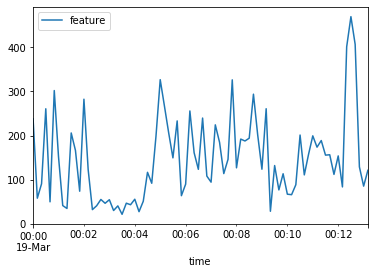

In [16]:
train.plot()

In [17]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [18]:
test_result=adfuller(train['feature'])

In [19]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [20]:
adfuller_test(train['feature'])

ADF Test Statistic : -5.945866499650217
p-value : 2.205049473411678e-07
#Lags Used : 0
Number of Observations Used : 79
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Auto Regressive Model

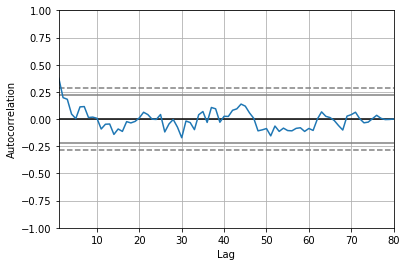

In [22]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train['feature'])
plt.show()

### Thoughts on Autocorrelation and Partial Autocorrelation

In [26]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot

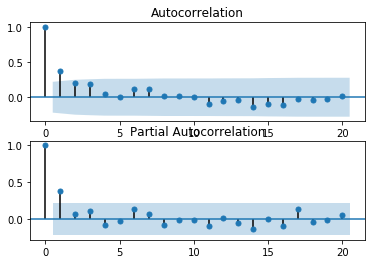

In [27]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(train, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train, ax=pyplot.gca())
pyplot.show()

In [32]:
#p=0, d=1, q=1 or 2
import statsmodels.api as sm

In [62]:
mod = sm.tsa.statespace.SARIMAX(train['feature'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\DINESH\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5917      0.110     -5.371      0.000      -0.808      -0.376
ma.S.L12      -0.5774      0.229     -2.524      0.012      -1.026      -0.129
sigma2      1.234e+04   2423.561      5.091      0.000    7588.986    1.71e+04


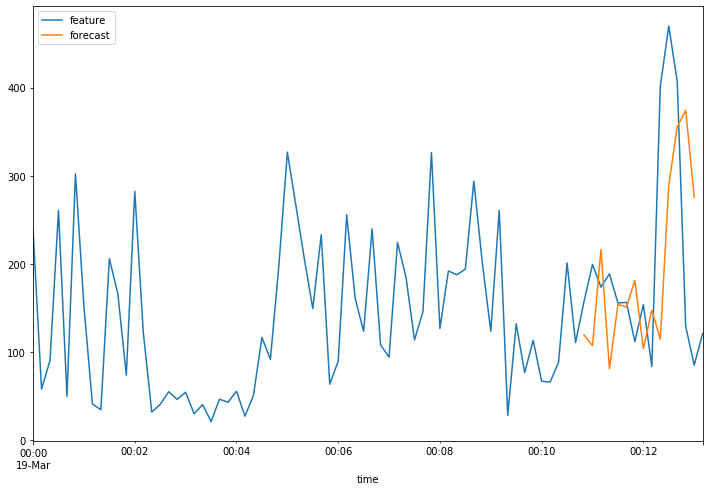

In [59]:
train['forecast']=results.predict(start=65,end=78,dynamic=False)
train[['feature','forecast']].plot(figsize=(12,8))

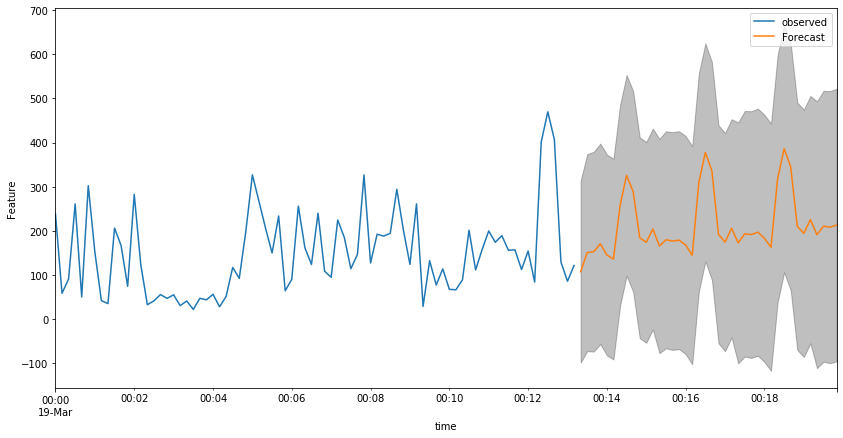

In [85]:
pred_test = results.get_forecast(steps=40)
pred_ci = pred_test.conf_int()

ax = train['feature'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('time')
ax.set_ylabel('Feature')

plt.legend()
plt.show()

### Compute the mean square error

In [79]:
mse = ((train['forecast'] - train['feature']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 17761.21


In [80]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 133.27


In [87]:
test1= pd.DataFrame(pred_test.predicted_mean)

In [89]:
test1.head()

,0
2019-03-19 00:13:20,106.877079
2019-03-19 00:13:30,150.195748
2019-03-19 00:13:40,152.372116
2019-03-19 00:13:50,170.157165
2019-03-19 00:14:00,144.927626


In [90]:
test1 = test1.reset_index(drop=True)

In [95]:
final_pred = pd.concat([test, test1], axis=1)

In [96]:
final_pred.head()

,id,time,0
0,80,2019-03-19 00:13:20,106.877079
1,81,2019-03-19 00:13:30,150.195748
2,82,2019-03-19 00:13:40,152.372116
3,83,2019-03-19 00:13:50,170.157165
4,84,2019-03-19 00:14:00,144.927626
